In [178]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
from astropy.constants import c
from astropy import constants as const
import astropy.units as u
from scipy import special


def weight(n):
    return 2 * n**2

def boltzmann(n1, n2, eV, T):
    k = 8.6173303e-5  # Boltzmann constant in eV/K
    g_n = weight(n2) / weight(n1) * np.exp(-eV / (k * T))
    return g_n

def CIV(T):
    sigma_Lya = 5.9e-14 * (T / 1e4) ** (-1/2)
    sigma_CIV = (0.19 / 0.4164) * sigma_Lya * (12) ** (0.5)
    N_CIV_0 = 1 / sigma_CIV
    return sigma_Lya, sigma_CIV, N_CIV_0

sig_ly, sig_c, N_CIV_0 = CIV(1e5)
print("{:.5e}".format(N_CIV_0))

def tau(sig_c, x):
    return sig_c * x

rr = np.arange(12, 18, 1)
ee = [13, 20, 32, 50, 79]
rr_reshaped = rr.reshape(-1, 1)
total_N_c = 10**rr_reshaped * ee / 10
total_N_c = total_N_c.flatten()

C_IV_K = 1548.187e-8  # cm
C_IV_H = 1550.772e-8  # cm
cc = c.to(u.cm / u.s).value
v_th_1 = 11.7673179819719e5  # cm/s

K_gamma = 2.65e+8
H_gamma = 2.64e+8
f_CIV_K = 0.190
f_CIV_H = 0.0952


NN = int(1e4)
xx = np.linspace(-5, 5, NN)
yy = np.linspace(-5, 5, NN)



def Voigt(x,v_th,gamma_line, lines):
    del_lam_D = v_th / lines
    a = gamma_line / (4 * np.pi * del_lam_D)
    dy = np.abs(yy[1] - yy[0])
    
    # Broadcasting and vectorized computation
    qq_minus_yy_squared = (x[:, np.newaxis] - yy)**2
    exp_neg_yy_squared = np.exp(-yy**2)
    
    summ = np.sum(exp_neg_yy_squared * dy / (qq_minus_yy_squared + a**2), axis=1)
    
    return summ * a / np.pi

def change_x_to_lam(x,v_th ,lines):
    del_lam_D = v_th / lines
    return lines / (x * v_th / cc + 1)


def N_esc_scat(v_th,N):
    C_iv_N = np.linspace(N, 1e17, NN)
    total_tau = np.zeros((len(C_iv_N), NN))

    # 벡터화된 tau 및 Voigt 프로파일 계산
    Voigt_profile = Voigt(xx,v_th_1,K_gamma, C_IV_K)
    tau_profile = tau(sig_c, C_iv_N[:, None]) * Voigt_profile

    # x_0 계산
    x_0 = np.zeros(len(C_iv_N))
    for ii, jj in enumerate(C_iv_N):
        x_p = np.where(np.diff(np.sign(1 - tau_profile[ii, :])))[0]
        x_0[ii] = xx[x_p].max() if x_p.size > 0 else 0

    del_lam_D = v_th / C_IV_K
    nu_0_K= cc/C_IV_K
    nu_esc = x_0*del_lam_D + nu_0_K
    V_del_peak = 2 * abs((nu_esc - nu_0_K)/nu_0_K) * cc/1e5 #km/s
    v_esc = x_0*v_th
    N_esc= 1/special.erfc(v_esc/v_th)

    return C_iv_N, N_esc , V_del_peak



3.39090e+13


In [179]:
# V_K_peak_1 = np.zeros(len(rr)*len(ee))

# V_H_peak_1 = np.zeros(len(rr)*len(ee))

# xx_1 = np.zeros(len(rr)*len(ee))
# scat_1 = np.zeros(len(rr)*len(ee))

C_IV_K_A = 1548.187  # cm
C_IV_H_A = 1550.772
v_th_2=26.3125229205449e5
v_th_3 = 37.2115267744875e5
directory_1 = '~/RT/C_IV/code_tes/data_C_IV/'
# /home/jin/바탕화면/C_IV/analy , '~/바탕화면/C_IV/code_tes/data_C_IV/'
v_th = [v_th_1,v_th_2,v_th_3]
v_loc = [118,263,372]
Tem = [1e5,5e5,10e5]
for tt,uu in enumerate(v_loc):
    n = 0 
    globals()[f'V_K_peak_{uu}'] = np.zeros(len(rr)*len(ee))
    globals()[f'V_H_peak_{uu}'] = np.zeros(len(rr)*len(ee))
    globals()[f'scat_{uu}'] = np.zeros(len(rr)*len(ee))
    globals()[f'xx_{uu}']= np.zeros(len(rr)*len(ee))
    iou = Tem[tt]
    sig_ly, sig_c, N_CIV_0 = CIV(iou)
    globals()[f'C_iv_{uu}'],globals()[f'N_scat_{uu}'],globals()[f'V_del_peak_{uu}'] = N_esc_scat(v_th[tt],N_CIV_0)

    
    for ii, num in enumerate(rr):
        for jj, bb in enumerate(ee):
            path_sp = f'{directory_1}N_atom{bb}0E+{num}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran{uu}E+01spec_com.dat'
            # path_sp_2 = f'{directory_1}N_atom{bb}0E+{num}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01spec_com.dat'
            # path_sp_3 = f'{directory_1}N_atom{bb}0E+{num}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01spec_com.dat'

            # Read data
            globals()[f'data_sp_{uu}_{bb}_{num}'] = pd.read_csv(path_sp, sep='\s+', header=None)
            globals()[f'sp_dlam_{uu}_{bb}_{num}'] = globals()[f'data_sp_{uu}_{bb}_{num}'][0]
            globals()[f'sp_{uu}_{bb}_{num}'] = globals()[f'data_sp_{uu}_{bb}_{num}'][2]

            # Find indices for K and H lines
            indices_K_1 = np.where(globals()[f'sp_dlam_{uu}_{bb}_{num}'] <= 1550)[0]
            indices_H_1 = np.where(globals()[f'sp_dlam_{uu}_{bb}_{num}'] > 1550)[0]
            # Create filtered series for K and H
            globals()[f'sp_dlam_K_{uu}_{bb}_{num}'] = globals()[f'sp_dlam_{uu}_{bb}_{num}'][indices_K_1]

            globals()[f'sp_dlam_H_{uu}_{bb}_{num}'] = globals()[f'sp_dlam_{uu}_{bb}_{num}'][indices_H_1]

            globals()[f'sp_K_{uu}_{bb}_{num}'] = globals()[f'sp_{uu}_{bb}_{num}'][indices_K_1]
            globals()[f'sp_H_{uu}_{bb}_{num}'] = globals()[f'sp_{uu}_{bb}_{num}'][indices_H_1]

            # # # Filter series for positive and negative wavelengths
            filtered_series_K_pos_1 = globals()[f'sp_K_{uu}_{bb}_{num}'].where(globals()[f'sp_dlam_K_{uu}_{bb}_{num}'] >= 0.01 + C_IV_K_A)
            filtered_series_K_neg_1 = globals()[f'sp_K_{uu}_{bb}_{num}'].where(globals()[f'sp_dlam_K_{uu}_{bb}_{num}'] <= -0.01 + C_IV_K_A)

            filtered_series_H_pos_1 = globals()[f'sp_H_{uu}_{bb}_{num}'].where(globals()[f'sp_dlam_H_{uu}_{bb}_{num}'] >=   0.01 + C_IV_H_A)
            filtered_series_H_neg_1 = globals()[f'sp_H_{uu}_{bb}_{num}'].where(globals()[f'sp_dlam_H_{uu}_{bb}_{num}'] <=  -0.01 + C_IV_H_A)

            # # Get peak indices
            K_p_1 = np.argmax(filtered_series_K_pos_1)
            K_n_1 = np.argmax(filtered_series_K_neg_1)

            H_p_1 = np.argmax(filtered_series_H_pos_1) + indices_H_1[0] 
            H_n_1 = np.argmax(filtered_series_H_neg_1) + indices_H_1[0] 
            # # Get peak values
            lam_K_1_1 = globals()[f'sp_dlam_K_{uu}_{bb}_{num}'][K_p_1]
            lam_K_2_1 = globals()[f'sp_dlam_K_{uu}_{bb}_{num}'][K_n_1]
            lam_H_1_1 = globals()[f'sp_dlam_H_{uu}_{bb}_{num}'][H_p_1]
            lam_H_2_1 = globals()[f'sp_dlam_H_{uu}_{bb}_{num}'][H_n_1]


            # plt.plot(globals()[f'sp_dlam_K_{uu}_{bb}_{num}'], globals()[f'sp_K_{uu}_{bb}_{num}'])
            # plt.plot(globals()[f'sp_dlam_H_{uu}_{bb}_{num}'], globals()[f'sp_H_{uu}_{bb}_{num}'])
            # plt.plot(globals()[f'sp_dlam_K_{uu}_{bb}_{num}'][K_p_1], globals()[f'sp_K_{uu}_{bb}_{num}'][K_p_1],'bo')
            # plt.plot(globals()[f'sp_dlam_K_{uu}_{bb}_{num}'][K_n_1], globals()[f'sp_K_{uu}_{bb}_{num}'][K_n_1],'ro')

            # plt.plot(globals()[f'sp_dlam_H_{uu}_{bb}_{num}'][H_p_1], globals()[f'sp_H_{uu}_{bb}_{num}'][H_p_1],'bo')
            # plt.plot(globals()[f'sp_dlam_H_{uu}_{bb}_{num}'][H_n_1], globals()[f'sp_H_{uu}_{bb}_{num}'][H_n_1],'ro')



            # # # Calculate peak velocity differences
            del_V_peak_K_1 = (abs(lam_K_1_1 - lam_K_2_1)*1e-8 / C_IV_K) * cc / 1e5
            del_V_peak_H_1 = (abs(lam_H_1_1 - lam_H_2_1)*1e-8   / C_IV_H) * cc /1e5


            # Check conditions and set velocities to 0 if conditions are met
            if globals()[f'sp_dlam_K_{uu}_{bb}_{num}'][K_p_1] <= globals()[f'sp_dlam_K_{uu}_{bb}_{num}'][K_p_1-1]:
                del_V_peak_K_1 = 0
            if globals()[f'sp_dlam_H_{uu}_{bb}_{num}'][H_p_1] <= globals()[f'sp_dlam_H_{uu}_{bb}_{num}'][H_p_1-1]:
                del_V_peak_H_1 = 0


            globals()[f'V_K_peak_{uu}'][n] = del_V_peak_K_1
            globals()[f'V_H_peak_{uu}'][n] = del_V_peak_H_1
            globals()[f'xx_{uu}'][n] = 10**num * bb / 10
            # print(del_V_peak_K_1)



            path_scat = f'{directory_1}N_atom{bb}0E+{num}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran{uu}E+01_f_esc.dat'

            globals()[f'data_scat_{uu}_{bb}_{num}'] = pd.read_csv(path_scat, sep='\s+', header=None)
            
            globals()[f'scat_{uu}'][n] = float(globals()[f'data_scat_{uu}_{bb}_{num}'].iloc[0,4])



            n += 1

In [180]:
V_K_peak_118

array([ 5.82859369,  8.75257259,  5.82859369,  7.30026519,  5.82859369,
        5.82859369,  5.82859369, 10.20487999, 16.03347368, 24.78604627,
       30.61463997, 36.44323366, 39.36721256, 42.27182736, 45.19580625,
       48.11978515, 51.02439995, 52.47670735, 55.40068624, 56.85299364,
       59.77697254, 61.22927994, 64.13389474, 65.58620213, 68.52954513,
       69.98185253, 71.43415993, 74.33877473, 75.81044622, 78.71506102])

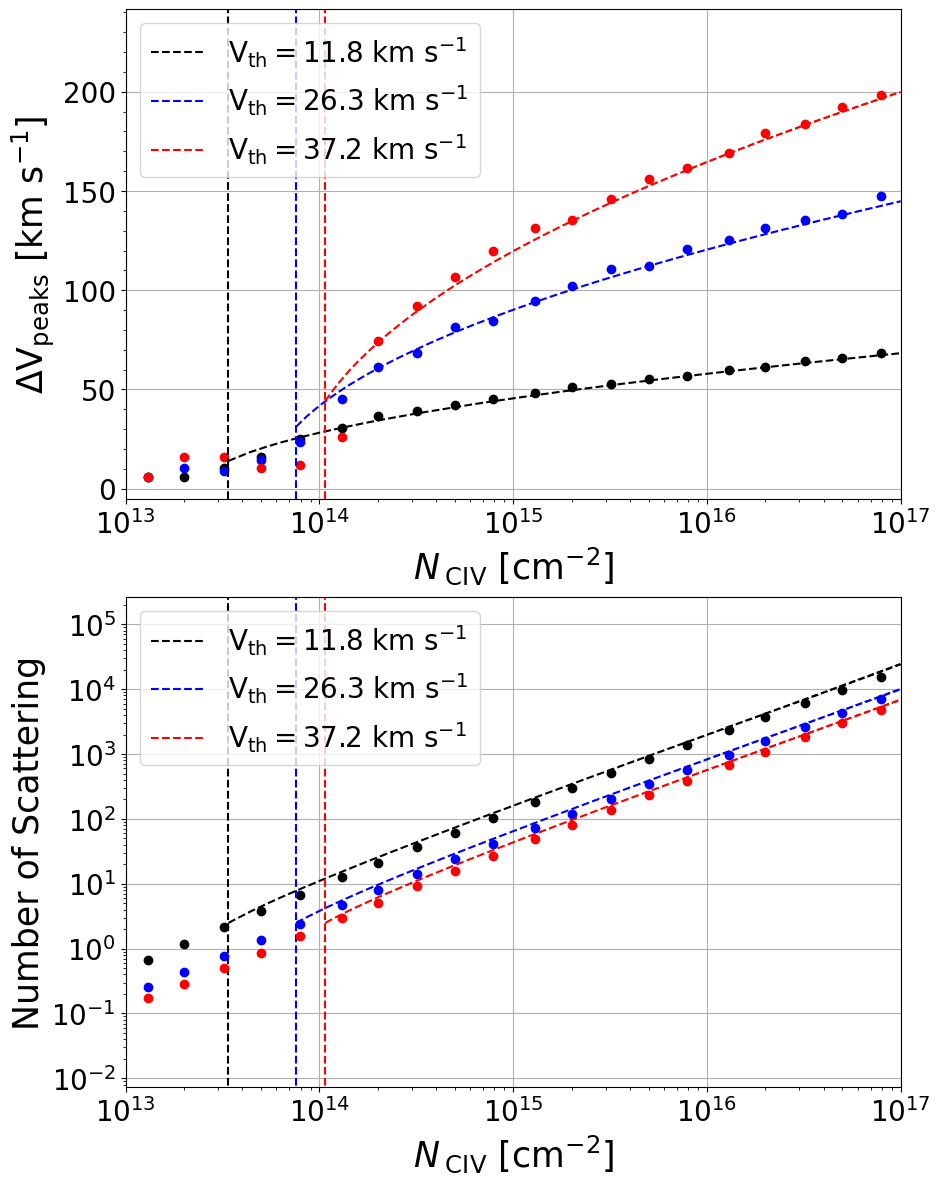

In [181]:
fig = plt.figure(1,figsize=(10,14))
# aa = np.where(x_0 > 0)
# xa= x_0[aa]

plt.subplot(211)
plt.plot(xx_118,V_K_peak_118,'ko')
plt.plot(xx_263,V_K_peak_263,'bo')
plt.plot(xx_372,V_K_peak_372,'ro')
plt.plot(C_iv_118,V_del_peak_118,'k--')
plt.plot(C_iv_263,V_del_peak_263,'b--')
plt.plot(C_iv_372,V_del_peak_372,'r--')
plt.axvline(x=3.39e13,ymin=0,ymax=80,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.axvline(x=7.58e+13,ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 26.3$ km s$^{-1}$')
plt.axvline(x=1.07230e+14,ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 37.2$ km s$^{-1}$')



plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =25)
plt.xscale('log')
plt.xlim(10**13,10**17)
# plt.ylim(V_K_peak_1.min()-2,V_K_peak_1.max()+2)
plt.ylabel(r'$\Delta \mathrm{V}_{\mathrm{peaks}}$ [km s$^{-1}$]',fontsize =25)
plt.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize=20,loc='upper left')

plt.subplot(212)
plt.plot(xx_118,scat_118,'ko')
plt.plot(C_iv_118,N_scat_118,'k--')
plt.axvline(x=3.39e13,ymin=N_scat_118.min()-10,ymax=2,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')

plt.plot(xx_263,scat_263,'bo')
plt.plot(C_iv_263,N_scat_263,'b--')
plt.axvline(x=7.58e13,ymin=N_scat_263.min()-10,ymax=2,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 26.3$ km s$^{-1}$')

plt.plot(xx_372,scat_372,'ro')
plt.plot(C_iv_372,N_scat_372,'r--')
plt.axvline(x=1.07e14,ymin=N_scat_372.min()-10,ymax=2,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 37.2$ km s$^{-1}$')


plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**13,10**17)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.ylim(scat.min(),scat.max()+2)
plt.ylabel(r'Number of Scattering',fontsize =25)
plt.minorticks_on()
plt.grid()
plt.legend(fontsize=20,loc='upper left')


# plt.savefig('/home/jin/바탕화면/simulation_vs_analyvic_jin_test.pdf',bbox_inches="tight")



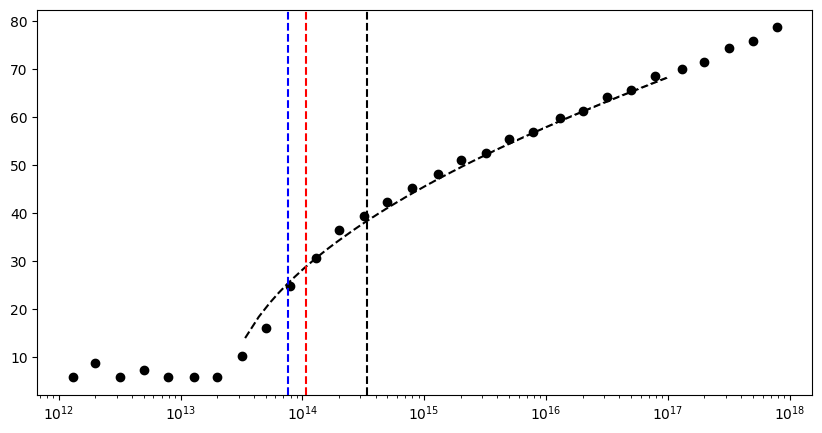

In [182]:
fig = plt.figure(1,figsize=(10,5))
# aa = np.where(x_0 > 0)
# xa= x_0[aa]

plt.plot(xx_118,V_K_peak_118,'ko')

plt.plot(C_iv_118,V_del_peak_118,'k--')

plt.axvline(x=3.39e14,ymin=0,ymax=80,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.axvline(x=7.58e+13,ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 26.3$ km s$^{-1}$')
plt.axvline(x=1.07230e+14,ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 37.2$ km s$^{-1}$')
plt.xscale('log')

0      -1934.957558
1      -1933.485886
2      -1932.033579
3      -1930.581272
4      -1929.128964
           ...     
1564     345.029510
1565     346.501181
1566     347.953489
1567     349.405796
1568     350.877468
Name: 0, Length: 1569, dtype: float64


Text(-0.39, 0.92, 'C IV K')

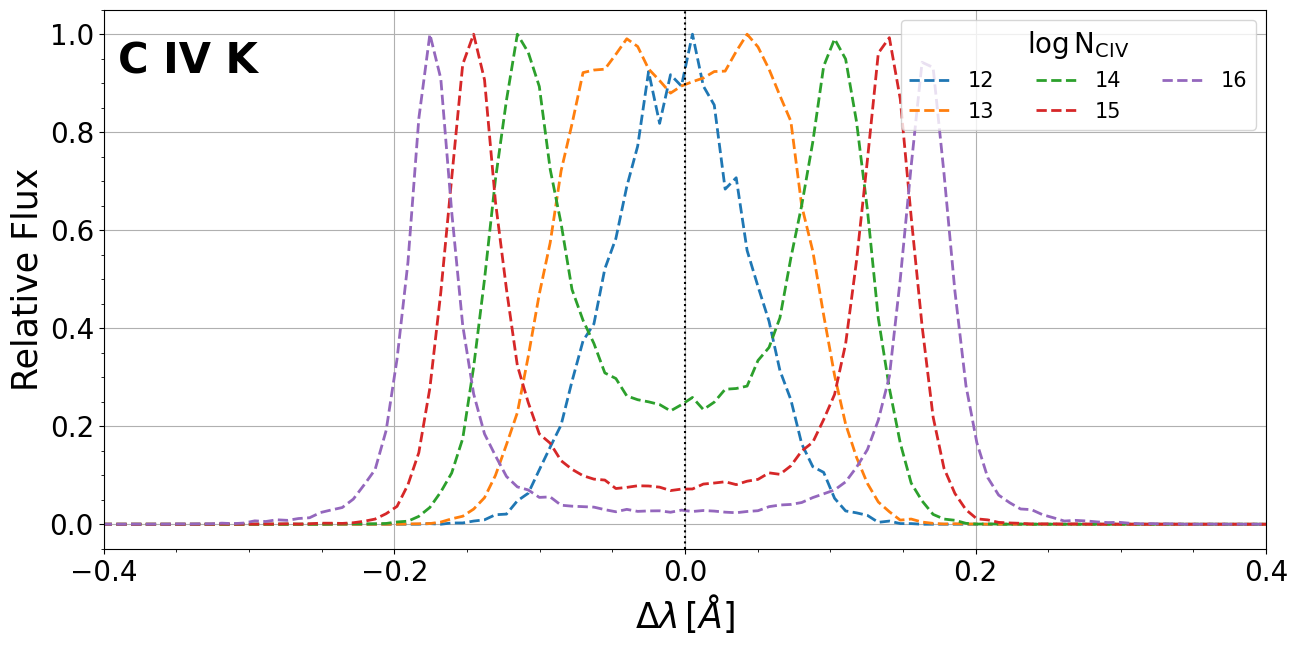

In [183]:
fig = plt.figure(1,figsize=(15,7))
nn = 50

n_0 = 12
plt.plot(globals()[f'sp_dlam_K_118_{nn}_{n_0}'] - C_IV_K_A,globals()[f'sp_K_118_{nn}_{n_0}']/globals()[f'sp_K_118_{nn}_{n_0}'].max(),'--',lw=2,label = f'{n_0}')


n_1 = 13
plt.plot(globals()[f'sp_dlam_K_118_{nn}_{n_1}'] - C_IV_K_A,globals()[f'sp_K_118_{nn}_{n_1}']/globals()[f'sp_K_118_{nn}_{n_1}'].max(),'--',lw=2,label = f'{n_1}')

n_2 = 14
plt.plot(globals()[f'sp_dlam_K_118_{nn}_{n_2}'] - C_IV_K_A,globals()[f'sp_K_118_{nn}_{n_2}']/globals()[f'sp_K_118_{nn}_{n_2}'].max(),'--',lw=2,label = f'{n_2}')

n_3 = 15
plt.plot(globals()[f'sp_dlam_K_118_{nn}_{n_3}']-C_IV_K_A,globals()[f'sp_K_118_{nn}_{n_3}']/globals()[f'sp_K_118_{nn}_{n_3}'].max(),'--',lw=2,label = f'{n_3}')

n_4 = 16
plt.plot(globals()[f'sp_dlam_K_118_{nn}_{n_4}']-C_IV_K_A,globals()[f'sp_K_118_{nn}_{n_4}']/globals()[f'sp_K_118_{nn}_{n_4}'].max(),'--',lw=2,label = f'{n_4}')



plt.xlim(-0.4,0.4)
plt.xticks(np.linspace(-0.4,0.4,5),fontsize=20)
plt.yticks(fontsize=20)

vel = (globals()[f'sp_dlam_K_118_{nn}_{n_0}'] - C_IV_K_A)/ C_IV_K_A * cc/1e5
print(vel)

plt.axvline(x=0,ymin=0,ymax=1,color='k',linestyle=':')
plt.xlabel(r'$\Delta \lambda \, [\AA]$',fontsize=25)
plt.ylabel('Relative Flux',fontsize=25)
plt.legend(fontsize=15,title=r'$\log {\rm N_{\rm C IV}}$',title_fontsize=20,ncol=3)
plt.minorticks_on()
plt.grid('True')
plt.text(-0.39,0.92,r'C IV K',fontweight='bold',fontsize=30)

# plt.savefig('/home/jin/바탕화면/double_peak_K_line.pdf',bbox_inches="tight")

Velocity Space

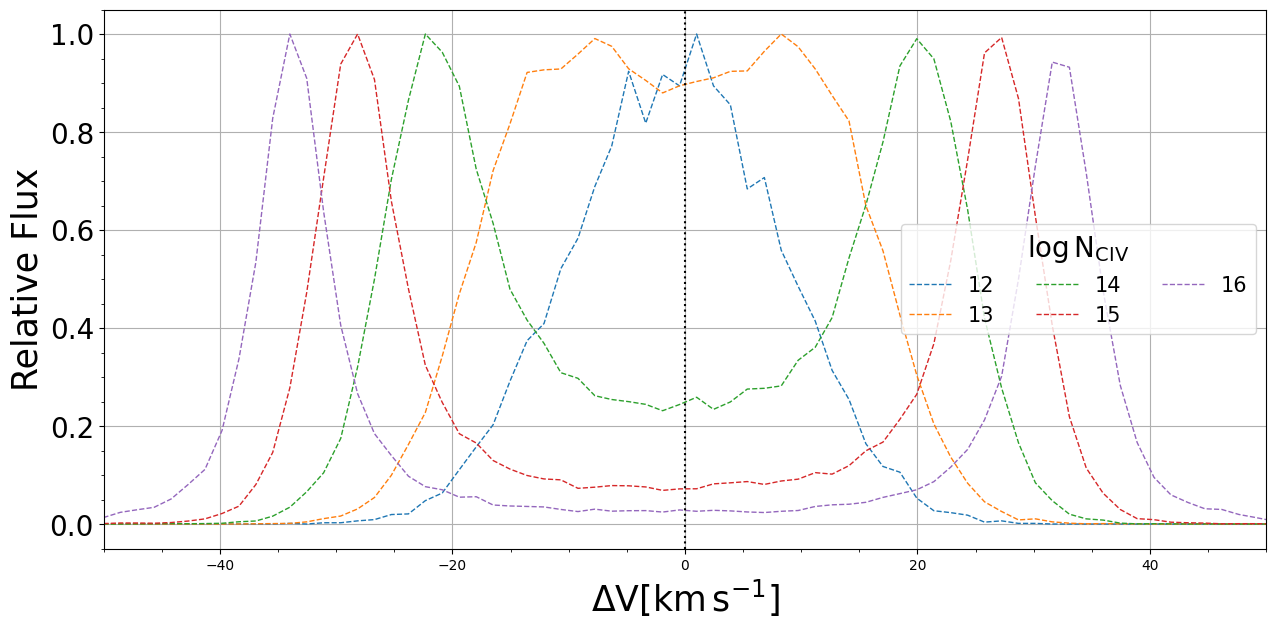

In [184]:
fig = plt.figure(1,figsize=(15,7))
nn = 50

n_0 = 12
# plt.plot(globals()[f'sp_dlam_K_118_{nn}_{n_0}'] - C_IV_K_A,globals()[f'sp_K_118_{nn}_{n_0}']/globals()[f'sp_K_118_{nn}_{n_0}'].max(),'--',lw=2,label = f'{n_0}')
Vel_0 = ((globals()[f'sp_dlam_K_118_{nn}_{n_0}'] - C_IV_K_A) / C_IV_K_A)*cc/1e5
plt.plot(Vel_0 ,globals()[f'sp_K_118_{nn}_{n_0}']/globals()[f'sp_K_118_{nn}_{n_0}'].max(),'--',lw=1,label = f'{n_0}')


n_1 = 13
# plt.plot(globals()[f'sp_dlam_K_118_{nn}_{n_1}'] - C_IV_K_A,globals()[f'sp_K_118_{nn}_{n_1}']/globals()[f'sp_K_118_{nn}_{n_1}'].max(),'--',lw=2,label = f'{n_1}')
Vel_0 = ((globals()[f'sp_dlam_K_118_{nn}_{n_1}'] - C_IV_K_A) / C_IV_K_A)*cc/1e5
plt.plot(Vel_0 ,globals()[f'sp_K_118_{nn}_{n_1}']/globals()[f'sp_K_118_{nn}_{n_1}'].max(),'--',lw=1,label = f'{n_1}')

n_2 = 14
Vel_0 = ((globals()[f'sp_dlam_K_118_{nn}_{n_2}'] - C_IV_K_A) / C_IV_K_A)*cc/1e5
plt.plot(Vel_0 ,globals()[f'sp_K_118_{nn}_{n_2}']/globals()[f'sp_K_118_{nn}_{n_2}'].max(),'--',lw=1,label = f'{n_2}')


n_3 = 15
Vel_0 = ((globals()[f'sp_dlam_K_118_{nn}_{n_3}'] - C_IV_K_A) / C_IV_K_A)*cc/1e5
plt.plot(Vel_0 ,globals()[f'sp_K_118_{nn}_{n_3}']/globals()[f'sp_K_118_{nn}_{n_3}'].max(),'--',lw=1,label = f'{n_3}')


n_4 = 16
Vel_0 = ((globals()[f'sp_dlam_K_118_{nn}_{n_4}'] - C_IV_K_A) / C_IV_K_A)*cc/1e5
plt.plot(Vel_0 ,globals()[f'sp_K_118_{nn}_{n_4}']/globals()[f'sp_K_118_{nn}_{n_4}'].max(),'--',lw=1,label = f'{n_4}')



plt.xlim(-50,50)
# plt.xticks(np.linspace(-0.4,0.4,5),fontsize=20)
plt.yticks(fontsize=20)

# vel = (globals()[f'sp_dlam_K_118_{nn}_{n_0}'] - C_IV_K_A)/ C_IV_K_A * cc/1e5
# print(vel)

plt.axvline(x=0,ymin=0,ymax=1,color='k',linestyle=':')
plt.xlabel(r'$\Delta \rm V [\rm km \, s^{-1}]$',fontsize=25)
plt.ylabel('Relative Flux',fontsize=25)
plt.legend(fontsize=15,title=r'$\log {\rm N_{\rm C IV}}$',title_fontsize=20,ncol=3)
plt.minorticks_on()
plt.grid('True')
# plt.text(-0.39,0.92,r'C IV K',fontweight='bold',fontsize=30)

# plt.savefig('/home/jin/바탕화면/double_peak_K_line.pdf',bbox_inches="tight")

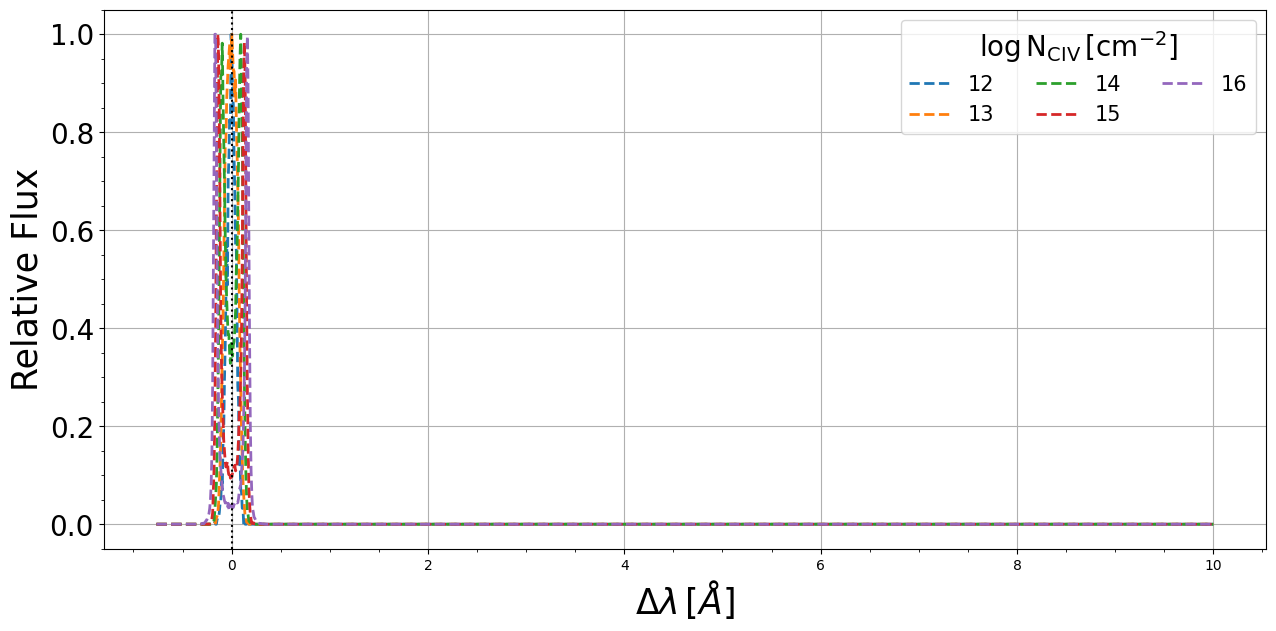

In [185]:
fig = plt.figure(1,figsize=(15,7))
nn = 50

n_0 = 12
plt.plot(globals()[f'sp_dlam_H_118_{nn}_{n_0}'] - C_IV_H_A,globals()[f'sp_H_118_{nn}_{n_0}']/globals()[f'sp_H_118_{nn}_{n_0}'].max(),'--',lw=2,label = f'{n_0}')


n_1 = 13
plt.plot(globals()[f'sp_dlam_H_118_{nn}_{n_1}'] - C_IV_H_A,globals()[f'sp_H_118_{nn}_{n_1}']/globals()[f'sp_H_118_{nn}_{n_1}'].max(),'--',lw=2,label = f'{n_1}')

n_2 = 14
plt.plot(globals()[f'sp_dlam_H_118_{nn}_{n_2}'] - C_IV_H_A,globals()[f'sp_H_118_{nn}_{n_2}']/globals()[f'sp_H_118_{nn}_{n_2}'].max(),'--',lw=2,label = f'{n_2}')

n_3 = 15
plt.plot(globals()[f'sp_dlam_H_118_{nn}_{n_3}']-C_IV_H_A,globals()[f'sp_H_118_{nn}_{n_3}']/globals()[f'sp_H_118_{nn}_{n_3}'].max(),'--',lw=2,label = f'{n_3}')

n_4 = 16
plt.plot(globals()[f'sp_dlam_H_118_{nn}_{n_4}']-C_IV_H_A,globals()[f'sp_H_118_{nn}_{n_4}']/globals()[f'sp_H_118_{nn}_{n_4}'].max(),'--',lw=2,label = f'{n_4}')



# plt.xlim(-0.4,0.4)
# plt.xticks(np.linspace(-0.4,0.4,5),fontsize=20)
plt.yticks(fontsize=20)

plt.axvline(x=0,ymin=0,ymax=1,color='k',linestyle=':')
plt.xlabel(r'$\Delta \lambda \, [\AA]$',fontsize=25)
plt.ylabel('Relative Flux',fontsize=25)
plt.legend(fontsize=15,title=r'$\log{\rm N_{\rm C IV}} \, [\rm cm^{-2}]$',title_fontsize=20,ncol=3)
plt.minorticks_on()
plt.grid('True')

# plt.text(-0.39,0.92,r'C IV H',fontweight='bold',fontsize=30)

# plt.savefig('/home/jin/바탕화면/double_peak_H_line.pdf',bbox_inches="tight")

/tmp/ipykernel_15280/685459019.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)


Text(0.5, 0, '$\\Delta \\rm V $ [km/s]')

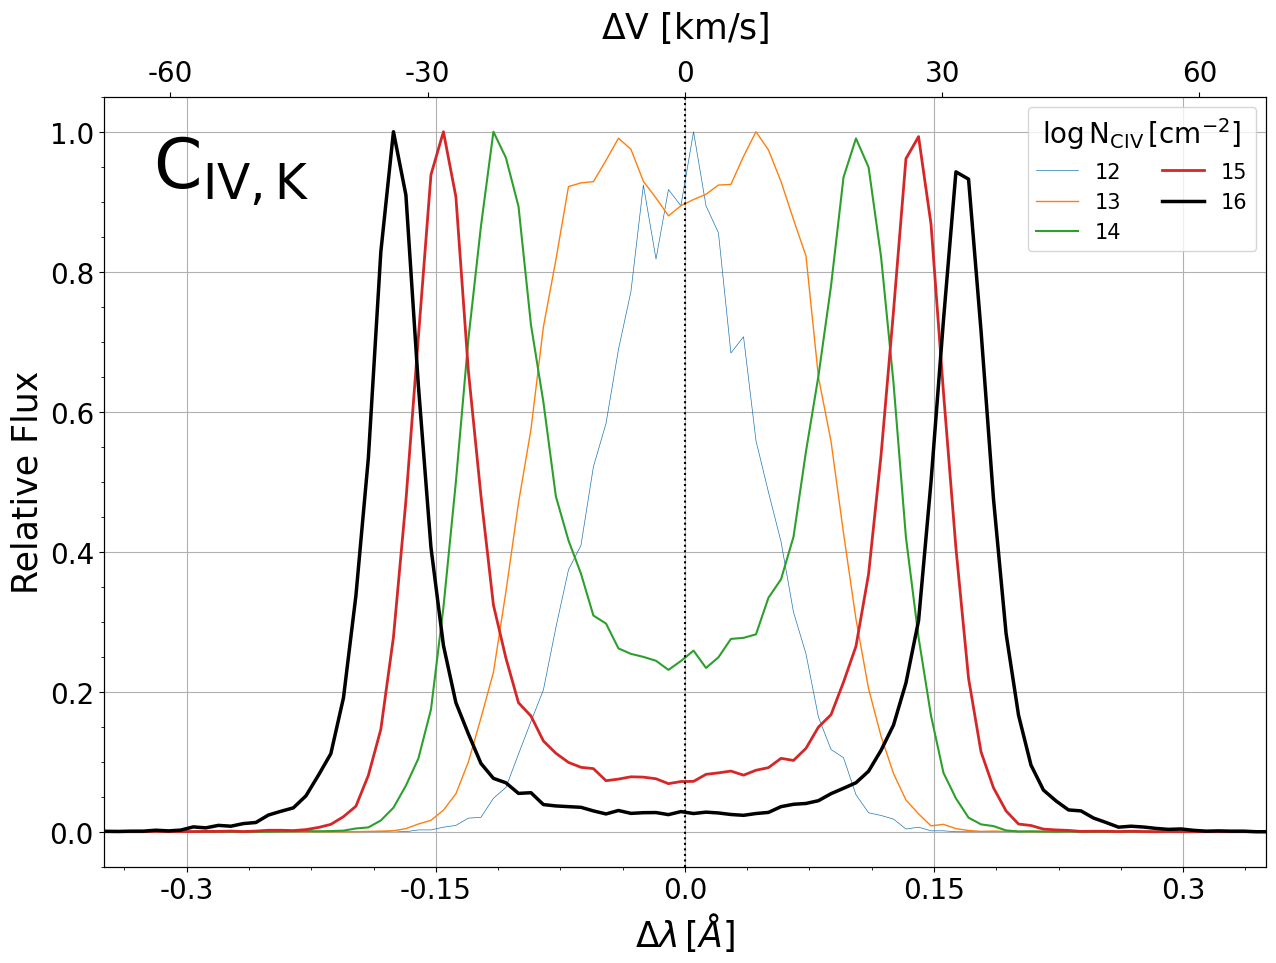

In [186]:



fig, ax1 = plt.subplots(figsize=(15, 10))



nn = 50

n_0 = 12
ax1.plot(globals()[f'sp_dlam_K_118_{nn}_{n_0}'] - C_IV_K_A,globals()[f'sp_K_118_{nn}_{n_0}']/globals()[f'sp_K_118_{nn}_{n_0}'].max(),'-',lw=0.5,label = f'{n_0}')


n_1 = 13
ax1.plot(globals()[f'sp_dlam_K_118_{nn}_{n_1}'] - C_IV_K_A,globals()[f'sp_K_118_{nn}_{n_1}']/globals()[f'sp_K_118_{nn}_{n_1}'].max(),'-',lw=1.0,label = f'{n_1}')

n_2 = 14
ax1.plot(globals()[f'sp_dlam_K_118_{nn}_{n_2}'] - C_IV_K_A,globals()[f'sp_K_118_{nn}_{n_2}']/globals()[f'sp_K_118_{nn}_{n_2}'].max(),'-',lw=1.5,label = f'{n_2}')

n_3 = 15
ax1.plot(globals()[f'sp_dlam_K_118_{nn}_{n_3}']-C_IV_K_A,globals()[f'sp_K_118_{nn}_{n_3}']/globals()[f'sp_K_118_{nn}_{n_3}'].max(),'-',lw=2,label = f'{n_3}')

n_4 = 16
ax1.plot(globals()[f'sp_dlam_K_118_{nn}_{n_4}']-C_IV_K_A,globals()[f'sp_K_118_{nn}_{n_4}']/globals()[f'sp_K_118_{nn}_{n_4}'].max(),'k-',lw=2.5,label = f'{n_4}')



ax1.set_xlim(-0.35, 0.35)
ax1.set_xticks(np.linspace(-0.3, 0.3, 5))  # x축 눈금 설정
ax1.set_xticklabels(np.round(np.linspace(-0.3, 0.3, 5),2), fontsize=20)
# ax1.set_xticklabels(np.linspace(-0.3, 0.3, 5), fontsize=20)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)
ax1.axvline(x=0, color='k', linestyle=':')
ax1.set_xlabel(r'$\Delta \lambda \, [\AA]$', fontsize=25)
ax1.set_ylabel('Relative Flux', fontsize=25)
ax1.legend(fontsize=15, title=r'$\log{\rm N_{\rm C IV}} \, [\rm cm^{-2}]$', title_fontsize=20, ncol=2)
ax1.minorticks_on()
ax1.grid(True)
ax1.text(-0.32, 0.92, r'$\rm C_{IV,K}$', fontweight='bold', fontsize=50)
# ax2 생성 및 설정
ax2 = ax1.twiny()

# Convert x-axis limits from angstroms to km/s
xlim = ax1.get_xlim()
vel_xlim = (np.array(xlim) / C_IV_K_A) * cc / 1e5
ax2.set_xlim(vel_xlim)

# ax2 설정
ax2.set_xticks(np.linspace(-60,60, 5))
ax2.set_xticklabels(np.linspace(-60, 60, 5).astype(int), fontsize=20)
ax2.set_xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
# plt.savefig('/home/jin/바탕화면/double_peak_K_line.pdf',bbox_inches="tight")

In [187]:
(-0.3 / C_IV_K_A) *cc/1e5

np.float64(-58.092295956496216)

/tmp/ipykernel_15280/333672086.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)


Text(0.5, 0, '$\\Delta \\rm V $ [km/s]')

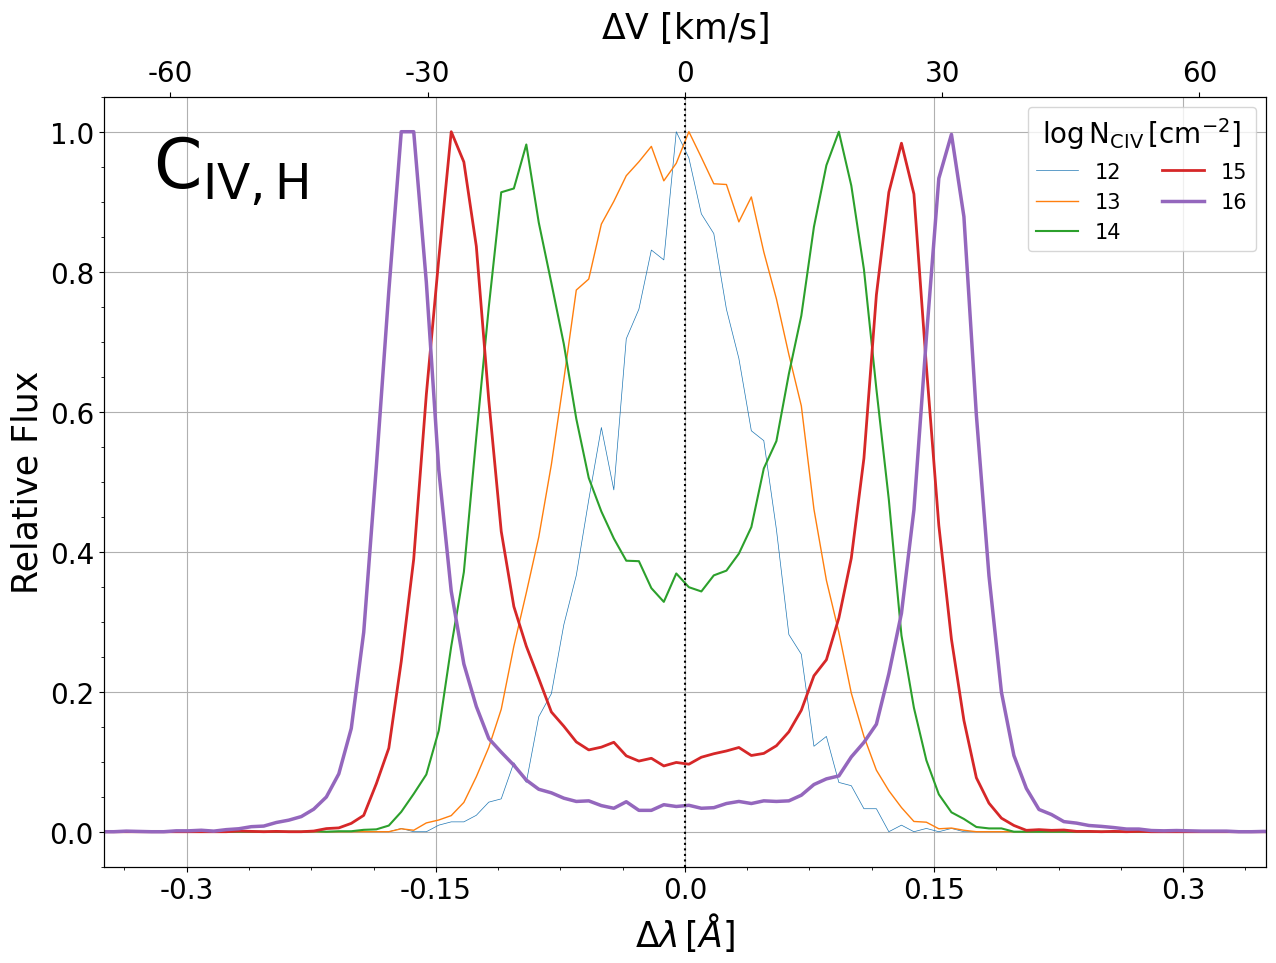

In [188]:


fig, ax1 = plt.figure(1, figsize=(15, 10)), plt.gca()



nn = 50

n_0 = 12
ax1.plot(globals()[f'sp_dlam_H_118_{nn}_{n_0}'] - C_IV_H_A,globals()[f'sp_H_118_{nn}_{n_0}']/globals()[f'sp_H_118_{nn}_{n_0}'].max(),'-',lw=0.5,label = f'{n_0}')


n_1 = 13
ax1.plot(globals()[f'sp_dlam_H_118_{nn}_{n_1}'] - C_IV_H_A,globals()[f'sp_H_118_{nn}_{n_1}']/globals()[f'sp_H_118_{nn}_{n_1}'].max(),'-',lw=1.0,label = f'{n_1}')

n_2 = 14
ax1.plot(globals()[f'sp_dlam_H_118_{nn}_{n_2}'] - C_IV_H_A,globals()[f'sp_H_118_{nn}_{n_2}']/globals()[f'sp_H_118_{nn}_{n_2}'].max(),'-',lw=1.5,label = f'{n_2}')

n_3 = 15
ax1.plot(globals()[f'sp_dlam_H_118_{nn}_{n_3}']-C_IV_H_A,globals()[f'sp_H_118_{nn}_{n_3}']/globals()[f'sp_H_118_{nn}_{n_3}'].max(),'-',lw=2,label = f'{n_3}')

n_4 = 16
ax1.plot(globals()[f'sp_dlam_H_118_{nn}_{n_4}']-C_IV_H_A,globals()[f'sp_H_118_{nn}_{n_4}']/globals()[f'sp_H_118_{nn}_{n_4}'].max(),'-',lw=2.5,label = f'{n_4}')



ax1.set_xlim(-0.35, 0.35)
ax1.set_xticks(np.linspace(-0.3, 0.3, 5))  # x축 눈금 설정
ax1.set_xticklabels(np.round(np.linspace(-0.3, 0.3, 5),2), fontsize=20)
# ax1.set_xticklabels(np.linspace(-0.3, 0.3, 5), fontsize=20)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)
ax1.axvline(x=0, color='k', linestyle=':')
ax1.set_xlabel(r'$\Delta \lambda \, [\AA]$', fontsize=25)
ax1.set_ylabel('Relative Flux', fontsize=25)
ax1.legend(fontsize=15, title=r'$\log{\rm N_{\rm C IV}} \, [\rm cm^{-2}]$', title_fontsize=20, ncol=2)
ax1.minorticks_on()
ax1.grid(True)
ax1.text(-0.32, 0.92, r'$\rm C_{IV,H}$', fontweight='bold', fontsize=50)
# ax2 생성 및 설정
ax2 = ax1.twiny()

# Convert x-axis limits from angstroms to km/s
xlim = ax1.get_xlim()
vel_xlim = (np.array(xlim) / C_IV_K_A) * cc / 1e5
ax2.set_xlim(vel_xlim)

# ax2 설정
ax2.set_xticks(np.linspace(-60,60, 5))
ax2.set_xticklabels(np.linspace(-60, 60, 5).astype(int), fontsize=20)
ax2.set_xlabel(r'$\Delta \rm V $ [km/s]', fontsize=25, labelpad=15)
# plt.savefig('/home/jin/바탕화면/double_peak_H_line.pdf',bbox_inches="tight")